In [1]:
import sys
sys.path.append("C:\\Users\\Kashyap\\bkp\\source\\repos\\efficient-det-siim-covid-19-challenge\\efficientdet-pytorch")
import glob
import os
import time
import random

import numpy as np
import pandas as pd
import PIL

from sklearn.model_selection import StratifiedKFold

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import torch
from torch.utils.data.dataset import Dataset
import torch.cuda.amp as amp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from map_boxes import mean_average_precision_for_boxes
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet


In [2]:
NFL_ROOT_DIR = r"C:\Users\Kashyap\bkp\source\repos\efficient-det-siim-covid-19-challenge\kaggle-nfl\nfl-health-and-safety-helmet-assignment"
TRAINING_DATA = os.path.join(NFL_ROOT_DIR, "train_labels.csv")
DATA_DIR = os.path.join(NFL_ROOT_DIR, "train_frames")

train_df = pd.read_csv(TRAINING_DATA)
labels = train_df["label"].unique()
NAME_TO_LABEL_MAP = {}
label_int_id = 0
for ind, key in enumerate(labels):
    if key[1:] not in NAME_TO_LABEL_MAP:
        NAME_TO_LABEL_MAP[key[1:]] = int(key[1:]) + 1
FOLDS = 5
SIZE = (1024, 1024)
NUM_CLASSES = len(labels)
BATCHSIZE = 2
SEED = 420
MODEL_NAME = "tf_efficientdet_d0"
ORIGINAL_IMAGE_WIDTH = 1280
ORIGINAL_IMAGE_HEIGHT = 720

In [3]:
validation_df = pd.read_csv('C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/tf_efficientdet_d1-0/tf_efficientdet_d1-0/best_mean_ap_preds.csv')

In [4]:
validation_df.head()

,XMin,YMin,XMax,YMax,Conf,LabelName,ImageID
0,921.450012,274.992065,939.247009,311.802185,0.380187,28,57583_000082_Endzone_112
1,480.470673,577.748779,502.012726,616.630371,0.328568,6,57583_000082_Endzone_112
2,921.450012,274.992065,939.247009,311.802185,0.318973,24,57583_000082_Endzone_112
3,921.308960,275.251953,939.371826,312.577454,0.315494,21,57583_000082_Endzone_112
4,480.470673,577.748779,502.012726,616.630371,0.298836,3,57583_000082_Endzone_112


In [5]:
# Make results reproducible
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)


In [6]:
def get_img_path(row):
    img_id = row["ImageID"]
    path = os.path.join(DATA_DIR,img_id+".jpg")
    if os.path.exists(path):
        return path
    else:
        # raise ValueError("Path does not exist {}".format(path))
        return None

In [7]:
validation_df["path"] = validation_df.apply(get_img_path, axis=1)
validation_df = validation_df[~validation_df["path"].isna()]


In [8]:
validation_df.Conf.unique()

array([0.38018718, 0.32856759, 0.318973  , ..., 0.12347871, 0.1231802 ,
       0.12303012])

In [10]:
def all_boxes_for_frame(group):
    return group[["XMin", "YMin", "XMax", "YMax", "LabelName","Conf"]].values.tolist()

if not os.path.exists(os.path.join(NFL_ROOT_DIR, "valData.csv")):
    print("Creating valData.csv")

    boxes_for_frame = validation_df.groupby(["ImageID"]).apply(all_boxes_for_frame)
    validation_samples_df = validation_df[["ImageID", "path"]]
    validation_samples_df.drop_duplicates(inplace=True)
        
    validation_samples_df.set_index("ImageID", inplace=True)
    validation_samples_df["boxes"] = boxes_for_frame
    validation_samples_df.to_csv(os.path.join(NFL_ROOT_DIR, "valData.csv"))
    del validation_samples_df

validation_samples_df = pd.read_csv(os.path.join(NFL_ROOT_DIR, "valData.csv"))
validation_samples_df.set_index("ImageID", inplace=True)

Creating valData.csv


<ipython-input-10-9e843039804a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_samples_df.drop_duplicates(inplace=True)
<ipython-input-10-9e843039804a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_samples_df["boxes"] = boxes_for_frame


In [11]:
validation_samples_df.head().iloc[1].boxes

'[[917.7501831054688, 278.0093078613281, 936.1934204101562, 315.4104919433594, 28.0, 0.3370274901390075], [481.4453430175781, 587.1522827148438, 501.4760437011719, 623.8523559570312, 6.0, 0.2972228825092315], [788.2098999023438, 353.4283142089844, 804.3599243164062, 389.7465515136719, 37.0, 0.29670450091362], [917.7501831054688, 278.0093078613281, 936.1934204101562, 315.4104919433594, 24.0, 0.2797591388225555], [140.33056640625, 478.6424560546875, 158.98995971679688, 518.9258422851562, 91.0, 0.2788300514221191], [276.597412109375, 0.9132318496704102, 290.49609375, 31.053653717041016, 31.0, 0.2645313739776611], [371.5357971191406, 440.32708740234375, 388.0986022949219, 473.6022338867188, 92.0, 0.2555221319198608], [481.4453430175781, 587.1522827148438, 501.4760437011719, 623.8523559570312, 3.0, 0.2543429732322693], [453.44830322265625, 394.4678649902344, 470.620361328125, 424.7189636230469, 92.0, 0.2498036921024322], [371.5357971191406, 440.32708740234375, 388.0986022949219, 473.6022338

In [28]:
class NFLDatasetFromDFHelmetAnnotations(Dataset):
    def __init__(
        self,
        df,
        train=True,
        predict=True,
        augment=True,
        data_dir=NFL_ROOT_DIR,
        size=SIZE,
    ):
        self.df = df
        self.label_list = NAME_TO_LABEL_MAP
        self.ids = df.index.sort_values()  # [:100]
        self.path_suffix = data_dir
        self._augment = augment
        self._train = train
        self._predict = predict
        self._size = size
        self._transform_list = [
            # A.Resize(size[0], size[1], p=1)
        ]

        if self._augment:
            self._transform_list.extend(
                [
                    A.VerticalFlip(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.ShiftScaleRotate(
                        scale_limit=0.20,
                        rotate_limit=10,
                        shift_limit=0.1,
                        p=0.5,
                        border_mode=cv2.BORDER_CONSTANT,
                        value=0,
                    ),
                    A.RandomBrightnessContrast(p=0.5),
                    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    # ToTensorV2(),
                ]
            )

        if self._train or self._predict:
            self._transform_list.extend(
                [
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2(),
                ]
            )

        if self._transform_list:

            self._transforms = A.Compose(
                self._transform_list,
                bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
            )
        self._preprocess_boxes()

    def _preprocess_boxes(self):
        self.id_bbox_map = {}
        scaled_w = self._size[1]
        scaled_h = self._size[0]
        opacity_count = 0
        none_count = 0
        for i, id in enumerate(self.ids):
            row = self.df.loc[id]
            all_boxes = []
            all_cats = []
            boxes = eval(row["boxes"])
            for annotation in boxes:
                box = {}
                # left,top,width,height
                # convert to center and normalize to 0, 1
                box["x"] = (
                    (max(0, int(annotation[0]))) * scaled_w / (ORIGINAL_IMAGE_WIDTH)
                )
                box["y"] = (
                    (max(0, int(annotation[1]))) * scaled_h / (ORIGINAL_IMAGE_HEIGHT)
                )
                box["width"] = int(annotation[2]) * scaled_w / ORIGINAL_IMAGE_WIDTH
                box["height"] = int(annotation[3]) * scaled_h / ORIGINAL_IMAGE_HEIGHT
                bbox = [
                    box["x"],
                    box["y"],
                    box["x"] + (box["width"]),
                    box["y"] + (box["height"]),
                ]

                all_boxes.append(bbox)
                all_cats.append(annotation[-1])
            self.id_bbox_map[id] = (all_boxes, all_cats)

    def __len__(self):
        return len(self.ids)

    def draw_bbox_idx(self, idx):
        img_id = self.ids[idx]
        row = self.df.loc[img_id]
        print(img_id)
        image = PIL.Image.open(row["path"])
        scaled_w = ORIGINAL_IMAGE_WIDTH
        scaled_h = ORIGINAL_IMAGE_HEIGHT
        print((scaled_w, scaled_h))
        boxes = eval(row["boxes"])
        image = image.resize((ORIGINAL_IMAGE_WIDTH,ORIGINAL_IMAGE_HEIGHT))
        draw = PIL.ImageDraw.Draw(image)
        areas_done = []
        for annotation in boxes:
            if(annotation[-1]>0.2):
                
                draw.rectangle(
                    [
                        int(annotation[0]) / SIZE[0] * scaled_w,
                        int(annotation[1]) / SIZE[1] * scaled_h,
                        int(annotation[2]) / SIZE[0] * scaled_w,
                        int(annotation[3]) / SIZE[1] * scaled_h,
                    ]
                )
                draw.text((int(annotation[0]) / SIZE[0] * scaled_w, int(annotation[1]) / SIZE[1] * scaled_h), str(int(annotation[4])),font=font,fill=(255,0,0,255))
        return image

    def _yolo_to_voc_format(self, yolo_bboxes):
        # takes in bounding boxes of the yolo format
        # converts them to voc format.
        # yolo format (x_c, y_c, width, height) normalized to 0, 1 by dividing by image dims.
        # voc format (x_min, y_min, x_max, y_max), unnormalized.
        scaled_w = self._size[1]
        scaled_h = self._size[0]
        bboxes_voc = torch.zeros_like(yolo_bboxes)
        # x_min = (x_c - width / 2) * scaled_w
        bboxes_voc[:, 0] = (yolo_bboxes[:, 0] - yolo_bboxes[:, 2] / 2) * scaled_w
        bboxes_voc[:, 1] = (yolo_bboxes[:, 1] - yolo_bboxes[:, 3] / 2) * scaled_h
        bboxes_voc[:, 2] = bboxes_voc[:, 0] + yolo_bboxes[:, 2] * scaled_w
        bboxes_voc[:, 3] = bboxes_voc[:, 1] + yolo_bboxes[:, 3] * scaled_h

        return bboxes_voc

    def draw_bbox_img(self, image, bboxes, label):
        image = PIL.Image.fromarray(image)
        draw = PIL.ImageDraw.Draw(image)
        for bbox in bboxes:
            # x_c = bbox[0]
            # y_c = bbox[1]
            # width = bbox[2]
            # height = bbox[3]
            # x_1 = (x_c - width / 2) * image.width
            # y_1 = (y_c - height / 2) * image.height
            # x_2 = x_1 + width * image.width
            # y_2 = y_1 + height * image.height
            # draw.rectangle([x_1, y_1, x_2, y_2])
            draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])
        print(f"Number of boxes{len(label)}")
        return image

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        boxes, labels = self.id_bbox_map[img_id]
        row = self.df.loc[img_id]

        path = row["path"]
        # ideally, we'd clean up the df,
        # but may be we use it to produce predictions as well.
        dicom_arr = cv2.imread(path)
        img = cv2.cvtColor(dicom_arr, cv2.COLOR_BGR2RGB)
        image_and_labels = {}
        if self._augment or (self._train or self._predict):
            image_and_labels = self._transforms(image=img, bboxes=boxes, labels=labels)
        else:
            image_and_labels = {"image": img, "bboxes": boxes, "labels": labels}

        # image_and_labels["bboxes"] = self._yolo_to_voc_format(
        #     torch.tensor(image_and_labels["bboxes"])
        # )

        # if not image_and_labels["bboxes"]:
        #     w = torch.rand(1) * 10
        #     h = torch.rand(1) * 10
        #     image_and_labels["bboxes"] = [[self._size[0] /2 - w, self._size[1]/2 - h, self._size[0]/2 + w, self._size[1]/2 + h]]
        #     image_and_labels["labels"] = [-1]
        # print(image_and_labels["bboxes"].shape)
        image_and_labels["bboxes"] = torch.tensor(image_and_labels["bboxes"]).to(
            dtype=torch.float32
        )
        image_and_labels["labels"] = torch.tensor(image_and_labels["labels"]).to(
            dtype=torch.long
        )

        return image_and_labels
    
    def bb_intersection_over_union(boxA, boxB):
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        # return the intersection over union value
        return iou
        
        


In [29]:
validation_ds = NFLDatasetFromDFHelmetAnnotations(df=validation_samples_df, train=False, predict=False, augment=False, size=SIZE)

57583_000082_Endzone_187
(1280, 720)


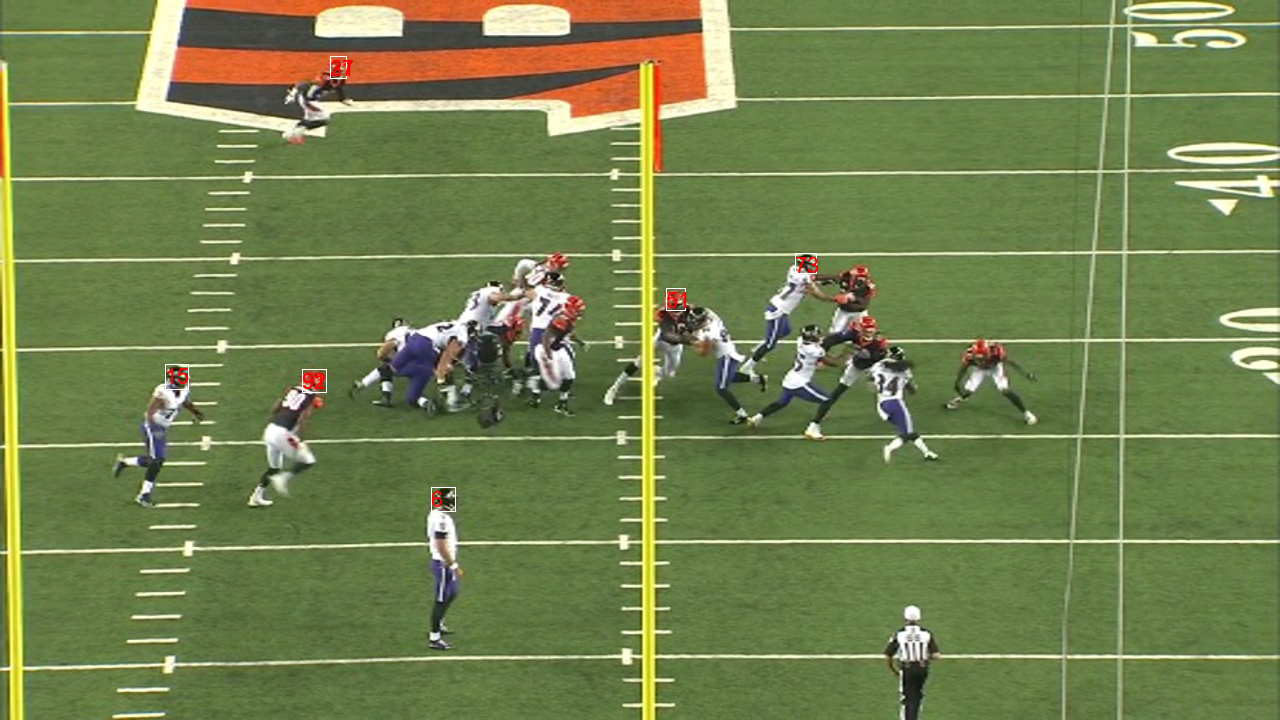

In [38]:
validation_ds.draw_bbox_idx(19)

In [15]:
fontsize = 22  # starting font size

# portion of image width you want text width to be
img_fraction = 0.50

font = PIL.ImageFont.truetype("arial.ttf", fontsize)

In [ ]:
data["bboxes"]

In [ ]:
preds_df = pd.read_csv('C:/Users/adars/Workspaces/covid19-contest-working-dir/efficient-det/best_mean_ap_preds.csv')

In [ ]:
preds_df[preds_df["ImageID"].str.contains(img_id)]

In [ ]:
boxes = preds_df[(preds_df["ImageID"].str.contains(img_id)) & (preds_df["Conf"] >= 0.35)][["XMin", "YMin", "XMax", "YMax"]].values
labels = preds_df[(preds_df["ImageID"].str.contains(img_id)) & (preds_df["Conf"] >= 0.35)][["LabelName"]].values
confs = preds_df[(preds_df["ImageID"].str.contains(img_id)) & (preds_df["Conf"] >= 0.35)][["Conf"]].values

In [ ]:
confs

In [ ]:
validation_ds.draw_bbox_img(image, boxes, labels)